In [40]:
import MilneEddington as ME
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import sys
import utils as ut
from tqdm import tqdm
from astropy.nddata import block_reduce
import astropy.convolution as ac
import scipy.ndimage as ndimage

In [48]:
# Modeling PSF
llambda_0 = 630E-9  # m
D = 1  # m
pixel_size = 16  # km

theta_0 = 1.22 * llambda_0 / D * 206265
theta_km = theta_0 * 720
theta_pixel = theta_km / pixel_size

# Creating Airy Disk 2D Kernel
psf = ac.AiryDisk2DKernel(theta_pixel)
psf.normalize()

# new_shape = (64, 64) # Original shape is (59, 59) - we 'set up' binning factor! Info is preserved.
# psf_resized = ndimage.zoom(psf, zoom=(new_shape[0] / psf.shape[0], new_shape[1] / psf.shape[1]), order=1)
# psf_resized /= np.sum(psf_resized)

# Binning PSF
bin_factor = 57 / 16  # desired pixel size / current pixel size
binned_psf = block_reduce(psf, block_size=(int(bin_factor), int(bin_factor)), func=np.mean)
binned_psf /= np.sum(binned_psf) # normalization
print(binned_psf.shape)

(19, 19)


### Before, we've tried to modify the original PSF size (59,59) to new shape that's more 'friendly' with the bin factor. 

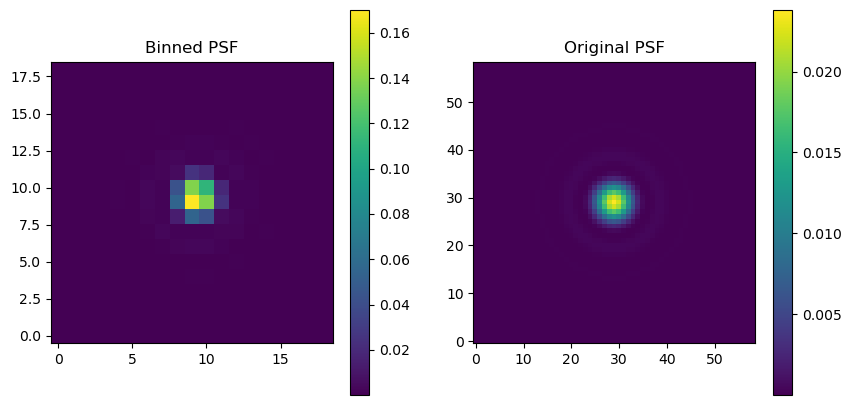

In [49]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(binned_psf, origin='lower')
plt.title('Binned PSF')
plt.colorbar()

plt.subplot(122)
plt.imshow(psf, origin='lower')
plt.title('Original PSF')
plt.colorbar()

plt.show()
#ut.writeFits('psf_1m_binned.fits', b_psf)

In [50]:
# Importing data
stokes_original = fits.open('qs_ph_disk_center_synth.fits')[0].data[:256, :256, :,:] # Shape: (1536, 1536, 4, 201)

# Convolution
convolved_data = np.zeros((stokes_original.shape))
for i in tqdm(range(stokes_original.shape[3])): 
    for j in range(stokes_original.shape[2]): 
        result = ac.convolve(stokes_original[:, :, j, i], binned_psf, boundary='wrap')
        convolved_data[:, :, j, i] = result
ut.writeFits('convolved.fits', convolved_data)   

100%|█████████████████████████████████████████| 201/201 [00:34<00:00,  5.84it/s]


[info] writeFits: writing -> convolved.fits


In [52]:
binned_data = np.zeros((convolved_data.shape[0] // int(bin_factor), convolved_data.shape[1] // int(bin_factor), convolved_data.shape[2], convolved_data.shape[3]))

# Binning
for i in tqdm(range(convolved_data.shape[3])):
    for j in range(convolved_data.shape[2]):
        # Binning 
        binned = block_reduce(convolved_data[:, :, j, i], block_size=(int(bin_factor), int(bin_factor)), func=np.mean)
        binned_data[:, :, j, i] = binned

ut.writeFits('binned_convolved.fits', binned_data)
print(binned_data.shape)

100%|█████████████████████████████████████████| 201/201 [00:06<00:00, 31.73it/s]


[info] writeFits: writing -> binned_convolved.fits
(85, 85, 4, 201)


In [54]:
# INVERSION

def waveGrid(nw):
    
    wav = np.arange(nw) * 0.01 + 6301.0
    return wav
    
def loadData(clip_threshold = 0.99):

    obs = binned_data[:64, :64, :,:]
    wav = waveGrid(obs.shape[-1])
    sig = np.zeros([4,len(wav)])
    sig[:,:] = 1e-3
    sig[1:4,:] /= 2.0
    
    return [[wav, None]], [[obs, sig, binned_psf, clip_threshold]]


if __name__ == "__main__":

    nthreads = 2 # adapt this number to the number of cores that are available in your machine
    
    # Load data
    region, sregion = loadData()

    # Init ME inverter
    me = ME.MilneEddington(region, [6301, 6302], nthreads=nthreads)
    
    # generate initial model
    ny, nx = sregion[0][0].shape[0:2]
    Ipar = np.float64([100, 0.1, 0.1, 0.0, 0.04, 100, 0.5, 0.1, 1.0]) # pay attention to the B value
    m = me.repeat_model(Ipar, ny, nx)
    

    mpix, syn, chi2 = me.invert(m, sregion[0][0], sregion[0][1], nRandom=10, nIter=50, chi2_thres=1.0, mu=0.96)
    ut.writeFits("modelout_ptp.fits", mpix)
    
     # smooth model
    m = ut.smoothModel(mpix, 4)


    # Invert spatially-coupled with initial guess from pixel-to-pixel (less iterations)
    m1, chi = me.invert_spatially_coupled(m, sregion, mu=1.0, nIter=10, alpha=2, \
                                      alphas=np.float64([1, 1, 1, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]), \
                                      init_lambda=10)

    # Smooth model with very narrow PSF and restart with less regularization (lower alpha)
    m = ut.smoothModel(m1, 2)

    # Invert spatially-coupled 
    m1, chi = me.invert_spatially_coupled(m, sregion, mu=1.0, nIter=15, alpha=0.75, \
                                     alphas=np.float64([2, 1, 1, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]), \
                                     init_lambda=1.0)
    ut.writeFits("modelout_sc.fits", m1)

line::line: Initialized [6301.499500] ->  12 Zeeman components
line::line: Initialized [6302.493100] ->   3 Zeeman components
InvertMany: Processed -> 100%


[info] writeFits: writing -> modelout_ptp.fits


[info] SparseRegion: Initializing degradation operator and cross-correlation matrix ... done
[info] invert: preallocating Hessian matrix ... populating ... done

[info] invert: sparse Hessian size -> 1.537589 GBytes

[info] invert: iter=  0, Chi2=  11327.76785 (5.682684e-02)
       [Constructing coupled linear system -> dt=76.608000 s]
       [Solving coupled linear system, Lambda=1.000000e+01: initial solution, solving system -> dt=5.370000 s]

[info] invert: iter=  1, Chi2=   9229.90124 (Reg=5.701446e-02), Lambda=1.000000e+01
       [Constructing coupled linear system -> dt=60.889000 s]
       [Solving coupled linear system, Lambda=3.636364e+00: initial solution, solving system -> dt=5.637000 s]

[info] invert: iter=  2, Chi2=   6651.07213 (Reg=6.456417e-02), Lambda=3.636364e+00
       [Constructing coupled linear system -> dt=66.909000 s]
       [Solving coupled linear system, Lambda=1.322314e+00: initial solution, solving system -> dt=11.300000 s]

[info] invert: iter=  3, Chi2=   

[info] writeFits: writing -> modelout_sc.fits


[info] SparseRegion: Initializing degradation operator and cross-correlation matrix ... done
[info] invert: preallocating Hessian matrix ... populating ... done

[info] invert: sparse Hessian size -> 1.537589 GBytes

[info] invert: iter=  0, Chi2=   3612.47255 (3.065048e-02)
       [Constructing coupled linear system -> dt=64.880000 s]
       [Solving coupled linear system, Lambda=1.000000e+00: initial solution, solving system -> dt=10.417000 s]

[info] invert: iter=  1, Chi2=   2921.60307 (Reg=6.089677e-02), Lambda=1.000000e+00
       [Constructing coupled linear system -> dt=63.798000 s]
       [Solving coupled linear system, Lambda=3.636364e-01: initial solution, solving system -> dt=10.809000 s]

[info] invert: iter=  2, Chi2=   2606.43280 (Reg=9.490246e-02), Lambda=3.636364e-01
       [Constructing coupled linear system -> dt=72.251000 s]
       [Solving coupled linear system, Lambda=1.322314e-01: initial solution, solving system -> dt=9.640000 s]

[info] invert: iter=  3, Chi2=  

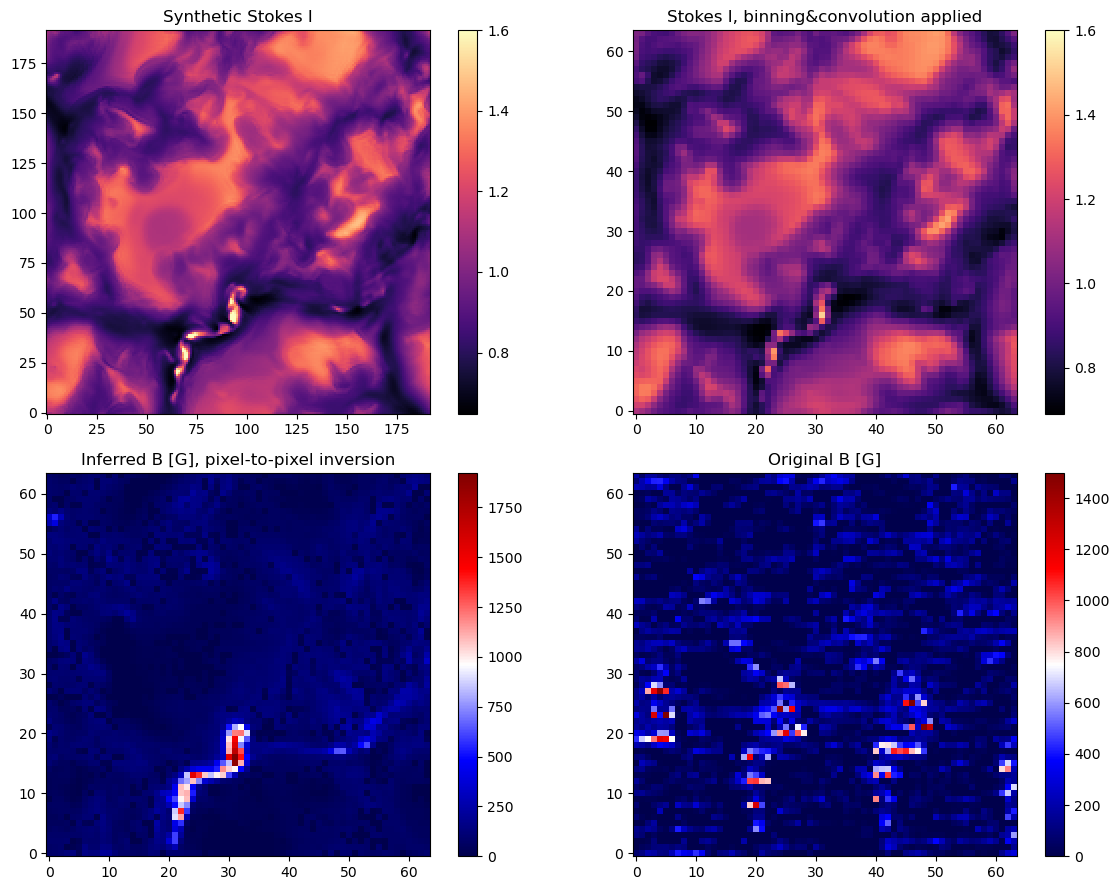

In [58]:
# Plotting

plt.figure(figsize=[12, 9])

stokes = fits.open('qs_ph_disk_center_synth.fits')[0].data[:256, :256, :, :]
binned = fits.open('binned_convolved.fits')[0].data
atmos = fits.open('qs_ph_disk_center.fits')[0].data[:, :, :512, :512]
modelout_ptp = fits.open('modelout_ptp.fits')[0].data
modelout_sc = fits.open('modelout_sc.fits')[0].data

plt.subplot(2, 2, 1)
plt.imshow(stokes[:192, :192, 0, 0], origin='lower', cmap='magma', vmax=1.6)
plt.title(r'Synthetic Stokes I')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(binned[:64,:64,0,0], origin='lower', cmap='magma', vmax=1.6)
plt.title(r'Stokes I, binning&convolution applied')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(modelout_ptp[:,:,0], origin='lower', cmap='seismic')
plt.title(r'Inferred B [G], pixel-to-pixel inversion')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(modelout_sc[:,:,0], origin='lower', cmap = 'seismic')
plt.title(r'Original B [G]')
plt.colorbar()
plt.tight_layout()

plt.show()